In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
sns.color_palette("flare")
%matplotlib inline

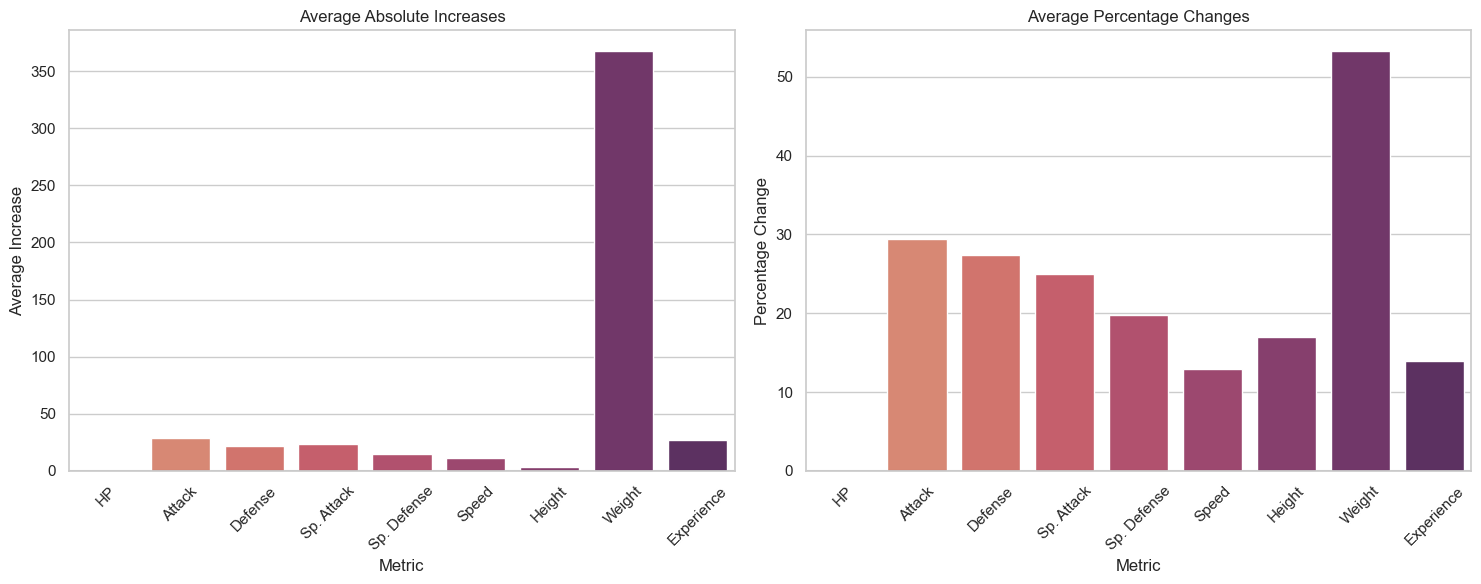

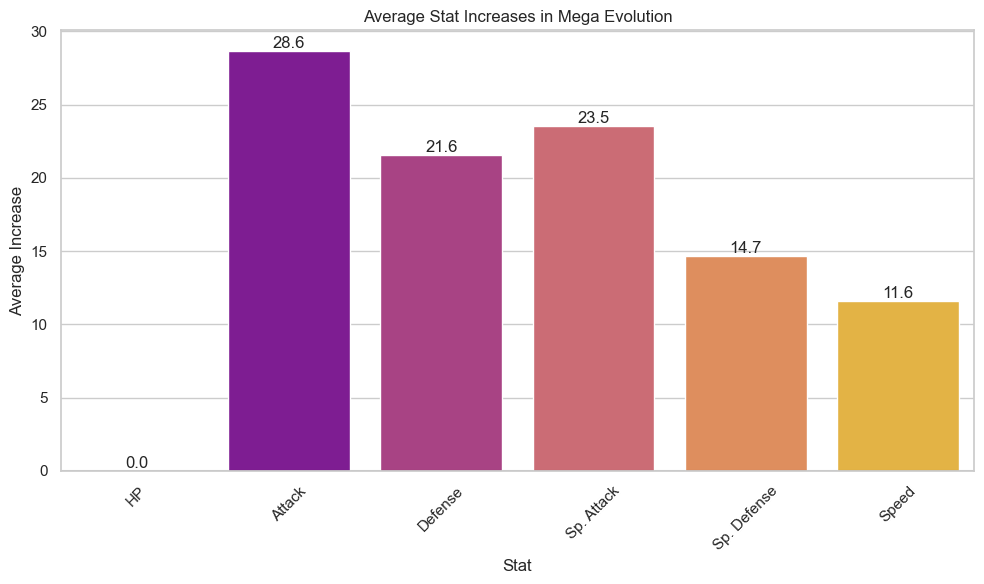

In [15]:
# 2. Les trois graphiques d'augmentation
common_metrics = [
    ('HP', 'base_hp', 'evolved_hp'),
    ('Attack', 'base_attack', 'evolved_attack'),
    ('Defense', 'base_defense', 'evolved_defense'),
    ('Sp. Attack', 'base_sp_attack', 'evolved_sp_attack'),
    ('Sp. Defense', 'base_sp_defense', 'evolved_sp_defense'),
    ('Speed', 'base_speed', 'evolved_speed'),
    ('Height', 'base_height', 'evolved_height'),
    ('Weight', 'base_weight', 'evolved_weight'),
    ('Experience', 'base_experience', 'evolved_experience')
]

stat_changes = pl.DataFrame({
    'Metric': [m[0] for m in common_metrics],
    'Average Increase': [
        df.select((pl.col(m[2]) - pl.col(m[1])).mean())[0,0]
        for m in common_metrics
    ],
    'Percentage Change': [
        df.select(((pl.col(m[2]) - pl.col(m[1])) / pl.col(m[1]) * 100).mean())[0,0]
        for m in common_metrics
    ]
})

# Définir une palette avec le nombre exact d'éléments
palette = sns.color_palette("flare", len(common_metrics))

# Créer deux subplots côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des changements absolus
sns.barplot(data=stat_changes.to_pandas(), x='Metric', y='Average Increase', ax=ax1, hue='Metric', palette=palette, legend=False)
ax1.set_title('Average Absolute Increases')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax1.tick_params(axis='x', rotation=45)

# Graphique des changements en pourcentage
sns.barplot(data=stat_changes.to_pandas(), x='Metric', y='Percentage Change', ax=ax2, hue='Metric', palette=palette, legend=False)
ax2.set_title('Average Percentage Changes')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Graphique spécifique des stats
stat_pairs = [
    ('HP', 'base_hp', 'evolved_hp'),
    ('Attack', 'base_attack', 'evolved_attack'),
    ('Defense', 'base_defense', 'evolved_defense'),
    ('Sp. Attack', 'base_sp_attack', 'evolved_sp_attack'),
    ('Sp. Defense', 'base_sp_defense', 'evolved_sp_defense'),
    ('Speed', 'base_speed', 'evolved_speed')
]

stat_changes = pl.DataFrame({
    'Stat': [pair[0] for pair in stat_pairs],
    'Average Increase': [
        df.select((pl.col(pair[2]) - pl.col(pair[1])).mean())[0,0]
        for pair in stat_pairs
    ]
})

# Définir une palette de couleurs
stat_palette = sns.color_palette("plasma", len(stat_pairs))

plt.figure(figsize=(10, 6))
bars = sns.barplot(data=stat_changes.to_pandas(), x='Stat', y='Average Increase', hue='Stat', palette=stat_palette, legend=False)
plt.title('Average Stat Increases in Mega Evolution')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars.patches):
    value = stat_changes['Average Increase'][i]
    bars.text(
        bar.get_x() + bar.get_width()/2.,
        bar.get_height(),
        f'{value:.1f}',
        ha='center',
        va='bottom'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

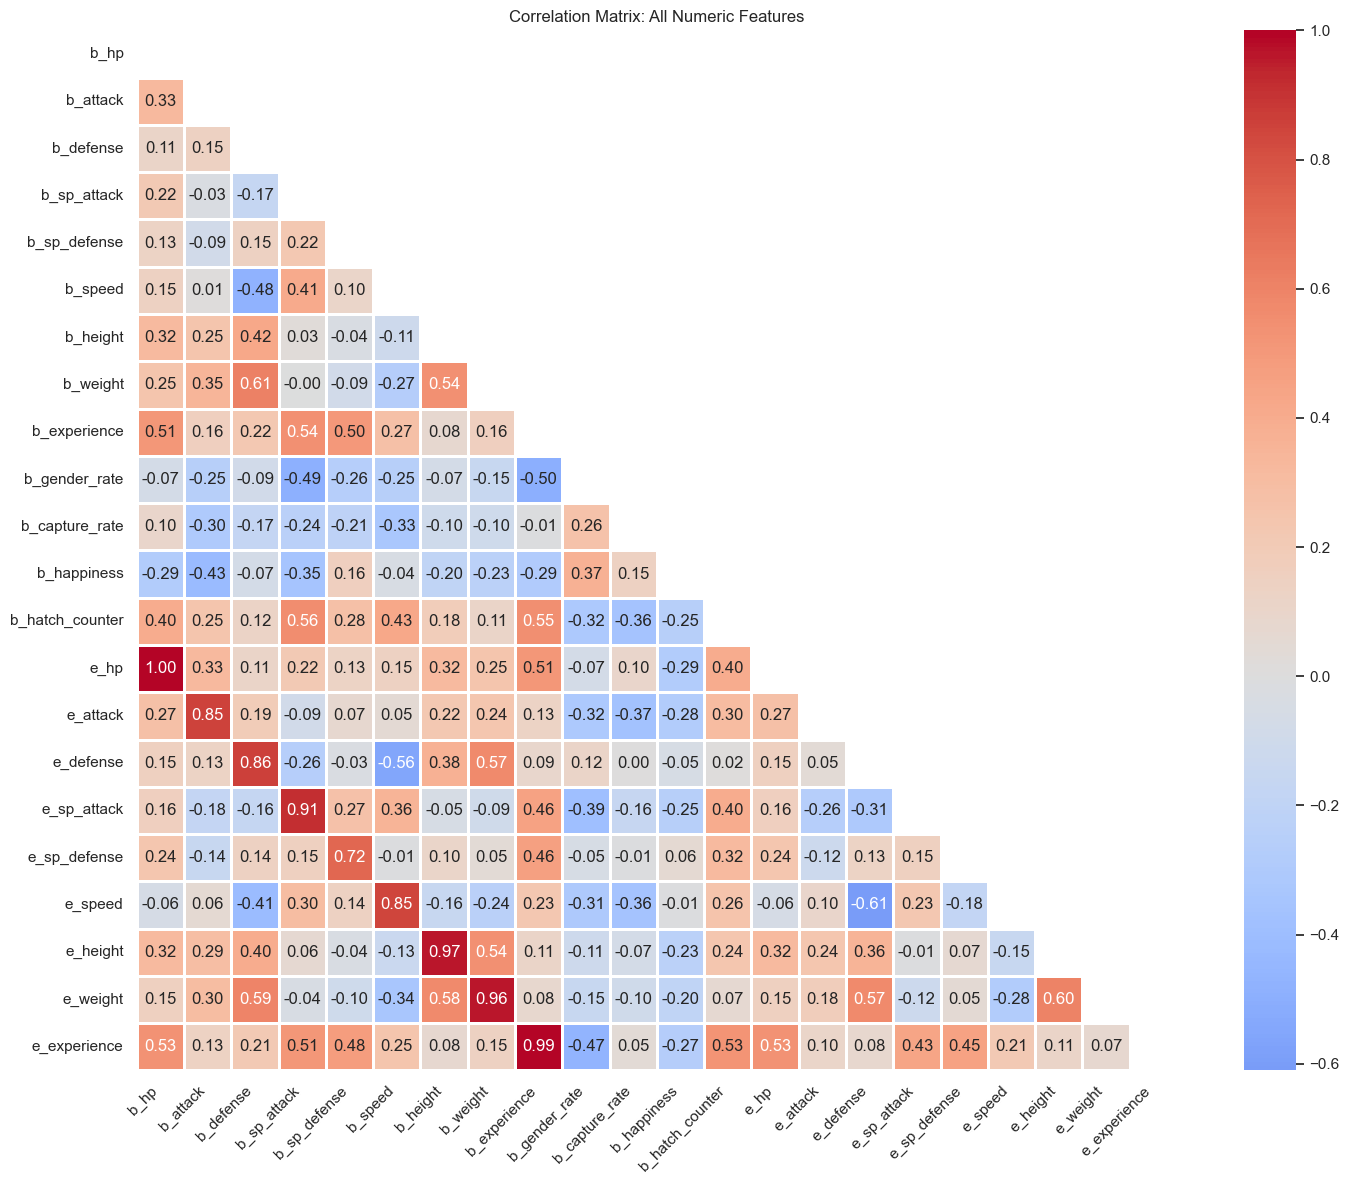

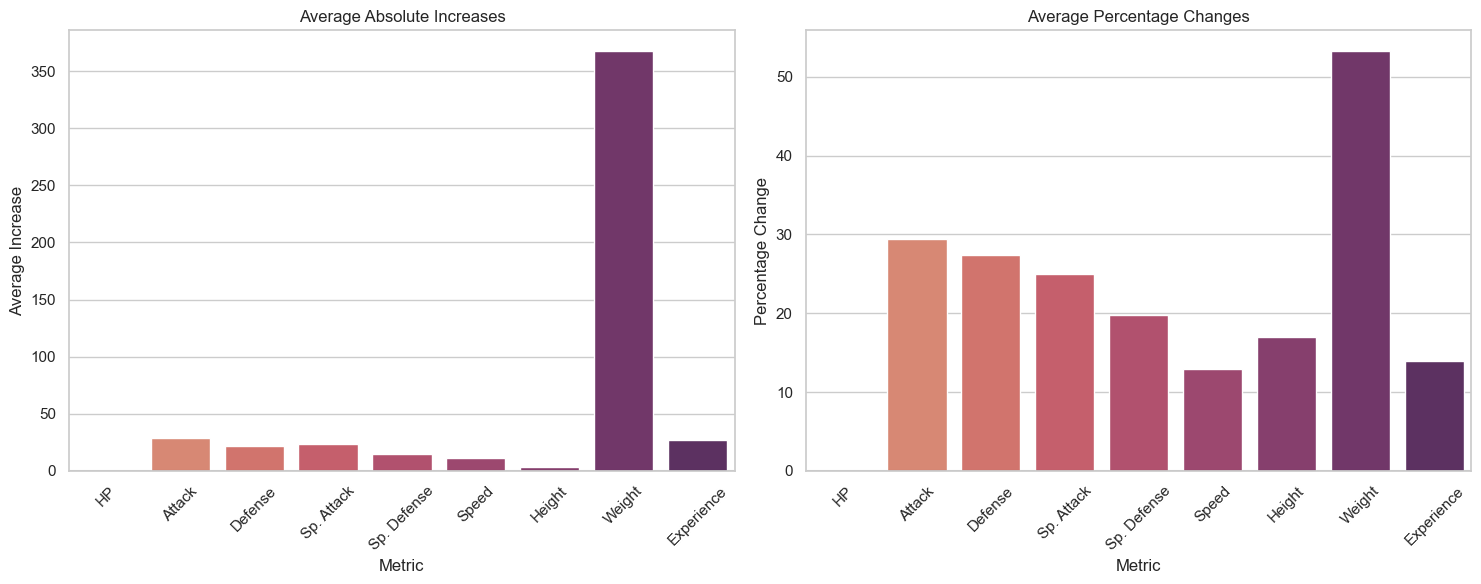

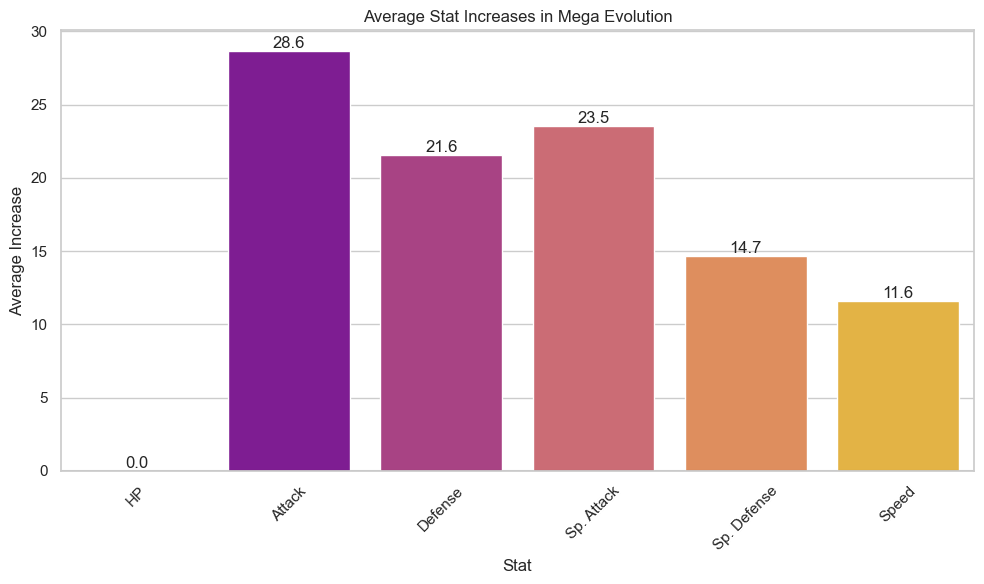

In [16]:
# Charger les données
df = pl.read_csv('../data/mega_evolutions.csv')

# 1. Matrice de corrélation complète
base_features = [
    'base_hp', 'base_attack', 'base_defense', 'base_sp_attack', 'base_sp_defense', 'base_speed',
    'base_height', 'base_weight', 'base_experience', 'base_gender_rate', 'base_capture_rate',
    'base_happiness', 'base_hatch_counter'
]

evolved_features = [
    'evolved_hp', 'evolved_attack', 'evolved_defense', 'evolved_sp_attack', 'evolved_sp_defense', 'evolved_speed',
    'evolved_height', 'evolved_weight', 'evolved_experience'
]

# Calculer la matrice de corrélation
stats_df = df.select(base_features + evolved_features)
corr_matrix = np.corrcoef(stats_df.to_numpy().T)

# Définir le style seaborn
sns.set(style='white')

# Créer une heatmap plus lisible
plt.figure(figsize=(15, 12))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

labels = [f.replace('base_', 'b_').replace('evolved_', 'e_') for f in (base_features + evolved_features)]

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            xticklabels=labels,
            yticklabels=labels)

plt.title('Correlation Matrix: All Numeric Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Les trois graphiques d'augmentation
common_metrics = [
    ('HP', 'base_hp', 'evolved_hp'),
    ('Attack', 'base_attack', 'evolved_attack'),
    ('Defense', 'base_defense', 'evolved_defense'),
    ('Sp. Attack', 'base_sp_attack', 'evolved_sp_attack'),
    ('Sp. Defense', 'base_sp_defense', 'evolved_sp_defense'),
    ('Speed', 'base_speed', 'evolved_speed'),
    ('Height', 'base_height', 'evolved_height'),
    ('Weight', 'base_weight', 'evolved_weight'),
    ('Experience', 'base_experience', 'evolved_experience')
]

stat_changes = pl.DataFrame({
    'Metric': [m[0] for m in common_metrics],
    'Average Increase': [
        df.select((pl.col(m[2]) - pl.col(m[1])).mean())[0,0]
        for m in common_metrics
    ],
    'Percentage Change': [
        df.select(((pl.col(m[2]) - pl.col(m[1])) / pl.col(m[1]) * 100).mean())[0,0]
        for m in common_metrics
    ]
})

# Définir le style seaborn
sns.set(style='whitegrid')

# Définir une palette avec le nombre exact d'éléments
palette = sns.color_palette("flare", len(common_metrics))

# Créer deux subplots côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des changements absolus
sns.barplot(data=stat_changes.to_pandas(), x='Metric', y='Average Increase', ax=ax1, hue='Metric', palette=palette, legend=False)
ax1.set_title('Average Absolute Increases')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax1.tick_params(axis='x', rotation=45)

# Graphique des changements en pourcentage
sns.barplot(data=stat_changes.to_pandas(), x='Metric', y='Percentage Change', ax=ax2, hue='Metric', palette=palette, legend=False)
ax2.set_title('Average Percentage Changes')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Graphique spécifique des stats
stat_pairs = [
    ('HP', 'base_hp', 'evolved_hp'),
    ('Attack', 'base_attack', 'evolved_attack'),
    ('Defense', 'base_defense', 'evolved_defense'),
    ('Sp. Attack', 'base_sp_attack', 'evolved_sp_attack'),
    ('Sp. Defense', 'base_sp_defense', 'evolved_sp_defense'),
    ('Speed', 'base_speed', 'evolved_speed')
]

stat_changes = pl.DataFrame({
    'Stat': [pair[0] for pair in stat_pairs],
    'Average Increase': [
        df.select((pl.col(pair[2]) - pl.col(pair[1])).mean())[0,0]
        for pair in stat_pairs
    ]
})

# Définir une palette de couleurs
stat_palette = sns.color_palette("plasma", len(stat_pairs))

plt.figure(figsize=(10, 6))
bars = sns.barplot(data=stat_changes.to_pandas(), x='Stat', y='Average Increase', hue='Stat', palette=stat_palette, legend=False)
plt.title('Average Stat Increases in Mega Evolution')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars.patches):
    value = stat_changes['Average Increase'][i]
    bars.text(
        bar.get_x() + bar.get_width()/2.,
        bar.get_height(),
        f'{value:.1f}',
        ha='center',
        va='bottom'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()